In [2]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import seed
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform 
import scipy.stats
import math
from sklearn.metrics import pairwise
from sklearn.metrics import mean_squared_error

In [72]:
T = 2
N = 100
x = 0.1 #initial stat3
x_N = 1 #gaussian noise in state update
x_R = 0.1 #noise covariance

V=2
x_P = np.zeros((N,1))
for i in range(N):
    #Initial particles
    x_P[i]= x + np.sqrt(V)*np.random.random()

z_out = np.zeros((T,1)) #the actual output vector for measurement values.
x_out = np.zeros((T,1)) #the actual output vector for state values.
x_est = np.zeros((T,1)) #time by time output of the particle filters estimate
x_est_out = np.zeros((T,1)) # the vector of particle filter estimates.

z_out[0] = x**2/20 + np.sqrt(x_R)*np.random.random()
x_out[0] = x   
x_est[0] = x 
x_est_out[0] = x_est[0] 

In [4]:
for t in range(1,T):
    x = 0.5*x + 25*x/(1 + x**2) + 8*math.cos(1.2*(t-1)) +  np.sqrt(x_N)*np.random.random()
    z = x**2/20 + np.sqrt(x_R)*np.random.random()    
    
    x_P_update = np.zeros((N,1))
    z_update = np.zeros((N,1))
    logP_w = np.zeros((N,1))
    for i in range(N):
        x_P_update[i] = 0.5*x_P[i] + 25*x_P[i]/(1 + x_P[i]**2) + 8*math.cos(1.2*(t-1)) + np.sqrt(x_N)*np.random.random()
        z_update[i] = x_P_update[i]**2/20        
        logP_w[i] = np.log(1/np.sqrt(2*math.pi*x_R)) - (z - z_update[i])**2/(2*x_R)
    print(x_P_update)
    print('ff')
    norm_weight = np.exp(logP_w-np.max(logP_w))
    norm_weight = norm_weight/np.sum(norm_weight)   
       
    #Resampling (The simplest resampling algorithm)
    cumulative_sum = np.cumsum(norm_weight)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.random(N))
    # resample according to indexes
    x_P[:] = x_P_update[indexes]
    
    #Final estimate of the resampling process , mean or variance of the new particles
    x_est[t] = np.mean(x_P)
    
    x_out[t] = x
    z_out[t] = z
    x_est_out[t] = x_est[t]
print('Error PF: ',mean_squared_error(x_out,x_est_out))
    

[[ 17.0540462 ]
 [ 19.24869491]
 [ 16.1604869 ]
 [ 21.55458621]
 [ 17.85321021]
 [ 21.27421922]
 [ 21.39265778]
 [ 14.79045787]
 [ 15.84760536]
 [ 15.63062184]
 [ 21.40192561]
 [ 14.19516666]
 [ 20.96142851]
 [ 15.62446459]
 [ 21.07625767]
 [ 21.29141735]
 [ 15.18995953]
 [ 21.30752456]
 [ 21.03098369]
 [ 20.98268549]
 [ 15.09326855]
 [ 18.23405454]
 [ 19.86459344]
 [ 17.21891647]
 [ 20.69518529]
 [ 20.35165274]
 [ 21.5833245 ]
 [ 21.81352888]
 [ 21.57182284]
 [ 21.17017454]
 [ 21.30513501]
 [ 13.60860206]
 [ 21.40403055]
 [ 21.36159139]
 [ 20.97060912]
 [ 21.55776807]
 [ 21.13746146]
 [ 21.14939661]
 [ 17.35490444]
 [ 21.13735032]
 [ 21.69235161]
 [ 21.08475342]
 [ 21.21926062]
 [ 21.39199551]
 [ 21.15108912]
 [ 20.80357821]
 [ 20.54777064]
 [ 20.77588262]
 [ 20.42938696]
 [ 16.10513897]
 [ 20.2397241 ]
 [ 21.43030469]
 [ 21.28302215]
 [ 21.38067446]
 [ 20.00597258]
 [ 21.64848064]
 [ 15.08987578]
 [ 12.85822397]
 [ 14.45492727]
 [ 21.29569318]
 [ 10.82968661]
 [ 20.06170892]
 [ 11.84

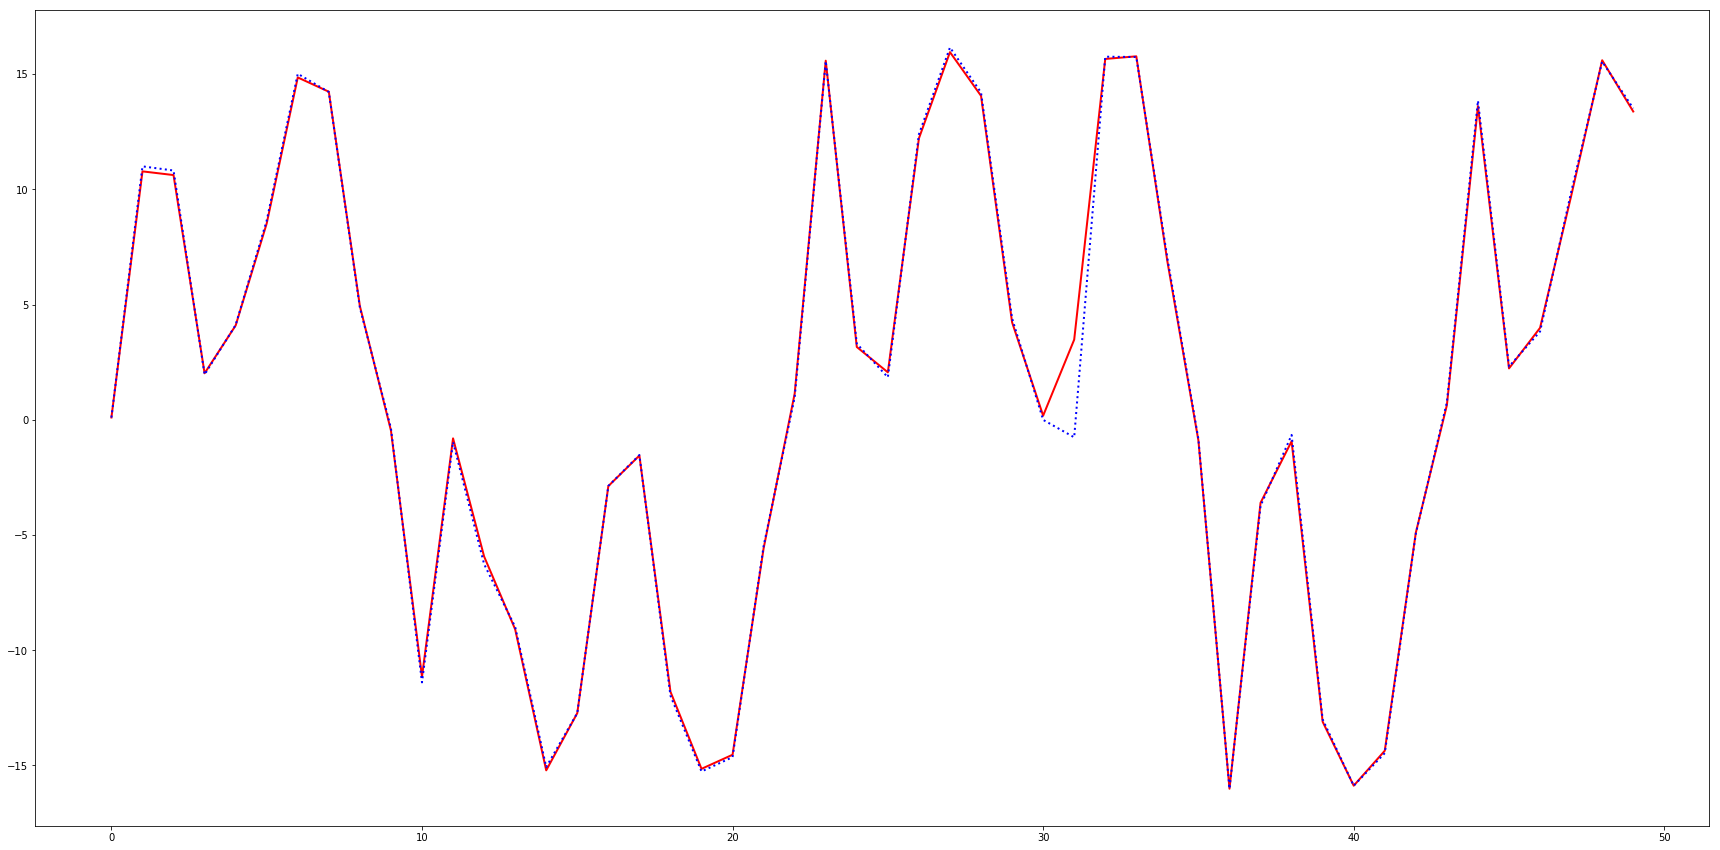

In [72]:
##Plotting the real position of the object vs. the estimated positions through time
plt.figure(figsize=(30,15))
plt.plot(x_out, color='r', linewidth=2)
plt.plot(x_est, ':k',color='b', linewidth=2)
plt.show()

In [50]:
def pf_aco(N , logWeights , x_P ):
    tau = np.zeros((N,N))
    #Assign the initial pheromones as particle weights
    weights = np.exp(logWeights)
    weights = np.exp(weights-np.max(weights))
    weights = weights/np.sum(weights) 
    for i in range(N):
        tau[:,i]=np.exp(logWeights[i])
    np.fill_diagonal(tau, 0)
    
    #pheromone evaporation rate
    rho = 0.5
    #threshold constant
    t_const = 7
    #deltaT : the amount of pheromone increase when an ant follows a path
    deltaT = 0.1
    #Eta parametresi reciprocal of the distances between particles to be calculated in the loop    
  
    numOfIts=0
    t_vector = np.zeros((N,1))
    while (numOfIts<6) or np.count_nonzero(t_vector)<1:
        #print('Iteration: ',numOfIts)
        #reciprocal of the distances between particles
        eta = 1/pairwise.pairwise_distances(X=x_P,Y=None,metric='euclidean')
        eta[np.isinf(eta)] = 0
        
        #For all particles, select pj to move towards according the ACO probability
        #Initialize the probability vector
        p = np.zeros((1,N))
        targetIdx = np.zeros((N,1))
        for i in range(N):
            p[0,:] = tau[i,:]*eta[i,:]/sum( tau[i,:]*eta[i,:])
            targetIdx[i]= np.argmax(p)
            #Move p_i towards target p_j
            x_P[i]=x_P[i]+(x_P[int(targetIdx[i])]-x_P[i])/2
        
        #Update the pheromone levels on the trails
        tau = (1-rho)*tau
        for i in range(N):
            tau[i,int(targetIdx[i])] = tau[i,int(targetIdx[i])]+deltaT
        
        #Check if all particles are with a certain threshold to their target particle
        print('thres')        
        for i in range(N):
            p_tar_Idx = int(targetIdx[i])
            threshold = (1-weights[p_tar_Idx])*np.random.uniform(low=0.0, high=1.0)*t_const
            if np.abs(x_P[i]-x_P[p_tar_Idx])<threshold:
                t_vector[i]=1
            #print(threshold)
        numOfIts = numOfIts+1
        print('numofIt:',numOfIts)
    return x_P  
    

In [18]:
N = 500;
logWeights = np.random.rand(N,1)
x_P = np.random.rand(N,1)
#print(x_P)
print('After:')
t , x_P = pf_aco(N , logWeights , x_P )
#print(t)

After:
Iteration:  0
Iteration:  1
Iteration:  2


c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


In [74]:
for t in range(1,T):
    x = 0.5*x + 25*x/(1 + x**2) + 8*math.cos(1.2*(t-1)) +  np.sqrt(x_N)*np.random.random()
    z = x**2/20 + np.sqrt(x_R)*np.random.random()    
    
    x_P_update = np.zeros((N,1))
    z_update = np.zeros((N,1))
    logP_w = np.zeros((N,1))
    for i in range(N):
        x_P_update[i] = 0.5*x_P[i] + 25*x_P[i]/(1 + x_P[i]**2) + 8*math.cos(1.2*(t-1)) + np.sqrt(x_N)*np.random.random()
        z_update[i] = x_P_update[i]**2/20        
        logP_w[i] = np.log(1/np.sqrt(2*math.pi*x_R)) - (z - z_update[i])**2/(2*x_R)
    
    ## Moved particles wrt ACO
    x_P_update_aco = pf_aco(N,logP_w,x_P_update)
    z_update_aco = np.zeros((N,1))
    logP_w_aco = np.zeros((N,1))
    for i in range(N):       
        z_update_aco[i] = x_P_update_aco[i]**2/20        
        logP_w_aco[i] = np.log(1/np.sqrt(2*math.pi*x_R)) - (z - z_update_aco[i])**2/(2*x_R)
    #Normalize the weights of aco-particles
    norm_weight_aco = np.exp(logP_w_aco-np.max(logP_w_aco))
    norm_weight_aco = norm_weight_aco/np.sum(norm_weight_aco)    
       
    #Resampling (The simplest resampling algorithm)
    cumulative_sum = np.cumsum(norm_weight_aco)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.random(N))
    # resample according to indexes
    x_P[:] = x_P_update_aco[indexes]
    
    #Final estimate of the resampling process , mean or variance of the new particles
    x_est[t] = np.mean(x_P)
    
    x_out[t] = x
    z_out[t] = z
    x_est_out[t] = x_est[t]

print('Error PF: ',mean_squared_error(x_out,x_est_out))

thres
numofIt: 1
thres
numofIt: 2
thres
numofIt: 3
thres
numofIt: 4
thres
numofIt: 5
thres
numofIt: 6
Error PF:  0.0104325780383


c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


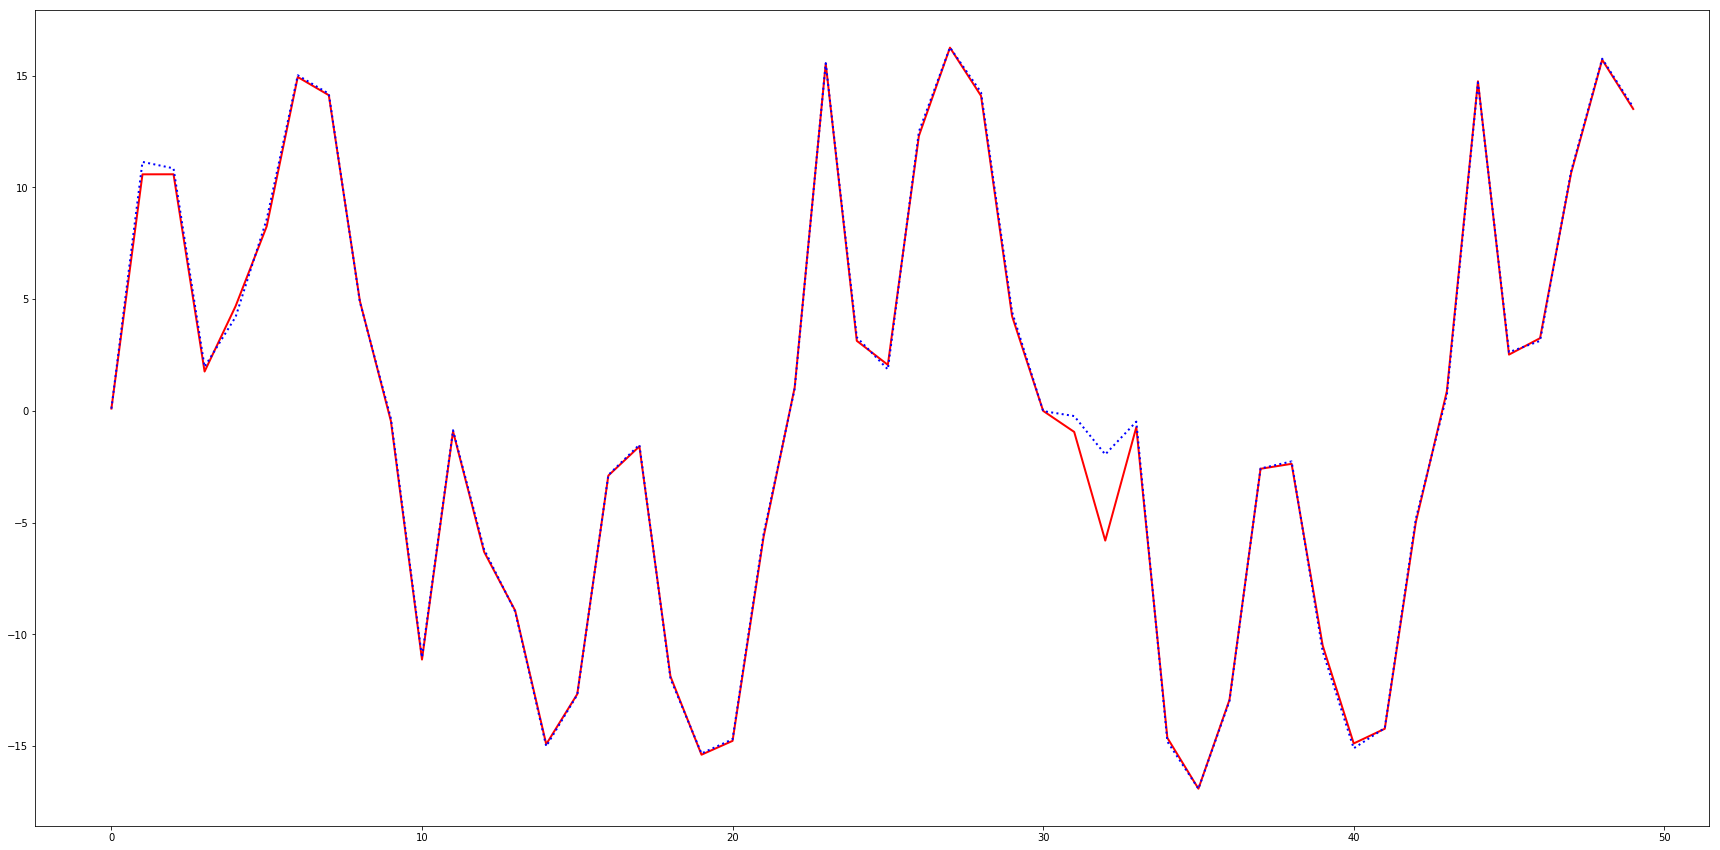

In [75]:
##Plotting the real position of the object vs. the estimated positions through time
plt.figure(figsize=(30,15))
plt.plot(x_out, color='r', linewidth=2)
plt.plot(x_est, ':k',color='b', linewidth=2)
plt.show()

In [4]:
from sklearn.metrics import pairwise
x = np.arange(3).reshape(3, 1)
print(x)

y = np.zeros((4,1))
dd = 1/pairwise.pairwise_distances(X=x,Y=None,metric='euclidean',n_jobs=-2)
dd[np.isinf(dd)] = 0
print(dd)
#from sklearn.metrics import pairwise

[[0]
 [1]
 [2]]
[[ 0.   1.   0.5]
 [ 1.   0.   1. ]
 [ 0.5  1.   0. ]]


c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [28]:
#plt.plot(x_P_update, 'bo', linewidth=2)
#plt.show()   

In [26]:
print(1.6*np.max(np.exp(logP_w)))

2.01649750346


In [ ]:
0.